In [24]:
# Librarys and Modules 

import pandas as pd 
import os
import copy
import statsmodels.api as sm
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,root_mean_squared_error
from sklearn.metrics import r2_score
import optuna
import seaborn as sns
import pandas_ta as ta
import matplotlib.pyplot as plt
import yfinance as yf


In [25]:
codes_list = ['ZC=F']
dfs_list = []
for i in codes_list:
#for each code in codes list(all available contracts until end of 2026), I create a ticker element 
#pull the historical dataframe and append to a list
    i_ticker = yf.Ticker(i)

    i_df = i_ticker.history(period = 'max')
    print(i_df.head())
    dfs_list.append(i_df)


                             Open    High     Low   Close  Volume  Dividends  \
Date                                                                           
2000-07-17 00:00:00-04:00  182.25  182.25  178.25  179.25   19385        0.0   
2000-07-18 00:00:00-04:00  179.00  183.25  179.00  180.75   25205        0.0   
2000-07-19 00:00:00-04:00  180.00  182.75  178.75  182.00   17126        0.0   
2000-07-20 00:00:00-04:00  181.50  187.00  181.00  186.00   18742        0.0   
2000-07-21 00:00:00-04:00  185.50  188.00  185.00  187.75   16814        0.0   

                           Stock Splits  
Date                                     
2000-07-17 00:00:00-04:00           0.0  
2000-07-18 00:00:00-04:00           0.0  
2000-07-19 00:00:00-04:00           0.0  
2000-07-20 00:00:00-04:00           0.0  
2000-07-21 00:00:00-04:00           0.0  


In [26]:
vix_code = '^VIX'
vix_ticker= yf.Ticker(vix_code)

vix_df = vix_ticker.history(period='max')
vix_df.index = vix_df.index.date
print(vix_df.head())
vix_df['vix'] = vix_df['Close'] 


                 Open       High        Low      Close  Volume  Dividends  \
1990-01-02  17.240000  17.240000  17.240000  17.240000       0        0.0   
1990-01-03  18.190001  18.190001  18.190001  18.190001       0        0.0   
1990-01-04  19.219999  19.219999  19.219999  19.219999       0        0.0   
1990-01-05  20.110001  20.110001  20.110001  20.110001       0        0.0   
1990-01-08  20.260000  20.260000  20.260000  20.260000       0        0.0   

            Stock Splits  
1990-01-02           0.0  
1990-01-03           0.0  
1990-01-04           0.0  
1990-01-05           0.0  
1990-01-08           0.0  


In [27]:
dow_code = 'YM=F'
dow_ticker = yf.Ticker(dow_code)

dow_df = dow_ticker.history(period = 'max')
dow_df.index = dow_df.index.date
dow_df['dow'] = dow_df['Close']
print(dow_df.head())
#dow jones e-mini continous cbot contracts 
#not a lot of improvement in r^2 but maybe will be better in RF once we get interaction terms

               Open     High      Low    Close  Volume  Dividends  \
2002-04-05  10246.0  10340.0  10222.0  10290.0    4234        0.0   
2002-04-08  10277.0  10280.0  10105.0  10268.0    4407        0.0   
2002-04-09  10290.0  10311.0  10205.0  10222.0    6189        0.0   
2002-04-10  10229.0  10399.0  10215.0  10383.0    6372        0.0   
2002-04-11  10378.0  10378.0  10158.0  10170.0    5387        0.0   

            Stock Splits      dow  
2002-04-05           0.0  10290.0  
2002-04-08           0.0  10268.0  
2002-04-09           0.0  10222.0  
2002-04-10           0.0  10383.0  
2002-04-11           0.0  10170.0  


In [28]:
gold_code = 'GC=F'
gold_ticker = yf.Ticker(gold_code)

gold_df = gold_ticker.history(period = 'max')
gold_df.index = gold_df.index.date
gold_df['gold'] = gold_df['Close']
print(gold_df.head())

                  Open        High         Low       Close  Volume  Dividends  \
2000-08-30  273.899994  273.899994  273.899994  273.899994       0        0.0   
2000-08-31  274.799988  278.299988  274.799988  278.299988       0        0.0   
2000-09-01  277.000000  277.000000  277.000000  277.000000       0        0.0   
2000-09-05  275.799988  275.799988  275.799988  275.799988       2        0.0   
2000-09-06  274.200012  274.200012  274.200012  274.200012       0        0.0   

            Stock Splits        gold  
2000-08-30           0.0  273.899994  
2000-08-31           0.0  278.299988  
2000-09-01           0.0  277.000000  
2000-09-05           0.0  275.799988  
2000-09-06           0.0  274.200012  


In [29]:
crude_code = 'CL=F'
crude_ticker = yf.Ticker(crude_code)

crude_df = crude_ticker.history(period = 'max')
crude_df.index = crude_df.index.date
crude_df['crude'] = crude_df['Close']
#adds 2nd closest contract of crude oil futures 

In [30]:
soybean_code = 'ZS=F'
soybean_ticker = yf.Ticker(soybean_code)

soybean_df = soybean_ticker.history(period = 'max')
soybean_df.index = soybean_df.index.date
soybean_df['soybean'] = soybean_df['Close']
#adds 2nd closest contract of soybean futures (subst with corn)

In [31]:
# Variables 
for i, df in enumerate(dfs_list):    
    # Daily Returns
    df.index = df.index.date
    df['Returns'] = df['Close'].pct_change() * 100
    df['Next Day Returns'] = df['Returns'].shift(-1)

    df['Month Returns'] = df['Close'].pct_change(periods = 28) * 100
    df['Month Returns'] = df['Month Returns'].shift(-28)
    #next week price
    df['Week Price'] = df['Close'].shift(-5)
    df['Month Price'] = df['Close'].shift(-28)

    #Relative Strength Index 
    df['Momentum RSI'] = ta.rsi(df['Close'], length=14)
    
    #Moving Average Convergence Divergence 
    macd = ta.macd(df['Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    df['MACD_signal'] = macd['MACDs_12_26_9']
    df['MACD_diff'] = df['MACD'] - df['MACD_signal']
    
    #Bollinger bands 
    bollinger_bands = ta.bbands(df['Close'], length=20)
    #Setting up Upper, Middle, and Lower bands 
    df['Bollinger_upper'] = bollinger_bands['BBU_20_2.0']
    df['Bollinger_middle'] = bollinger_bands['BBM_20_2.0']
    df['Bollinger_lower'] = bollinger_bands['BBL_20_2.0']
    #Bollinger Position 
    df['Bollinger_position'] = (df['Close'] - df['Bollinger_middle']) / (df['Bollinger_upper'] - df['Bollinger_lower'])


    #On-Balance Volume 
    df['OBV'] = ta.obv(df['Close'], df['Volume'])

    #Stochastic Oscillator 
    stoch = ta.stoch(df['High'], df['Low'], df['Close'])
    df['%K'] = stoch['STOCHk_14_3_3']
    df['%D'] = stoch['STOCHd_14_3_3']

    #Volume Weighted Average Price
    df['VWAP'] = (df['Close'] * df['Volume']).cumsum() / df['Volume'].cumsum()

    df = pd.merge(df, vix_df['vix'], left_index=True, right_index=True)
    df = pd.merge(df, dow_df['dow'], left_index=True, right_index=True)
    df = pd.merge(df, gold_df['gold'], left_index=True, right_index=True)
    df = pd.merge(df, crude_df['crude'], left_index=True, right_index=True)
    df = pd.merge(df, soybean_df['soybean'], left_index=True, right_index=True)

    print(df)
    
    df = df.dropna()
    dfs_list[i] = df  # Assign the modified df back to the list

dfs_dct = dict(zip(codes_list, dfs_list))

              Open    High     Low   Close  Volume  Dividends  Stock Splits  \
2002-04-05  201.50  201.75  201.25  201.50     219        0.0           0.0   
2002-04-08  200.50  200.75  200.25  200.75     243        0.0           0.0   
2002-04-09  201.50  202.00  201.50  202.00     161        0.0           0.0   
2002-04-10  201.25  201.50  201.00  201.25     430        0.0           0.0   
2002-04-11  199.75  200.25  199.75  198.75     134        0.0           0.0   
...            ...     ...     ...     ...     ...        ...           ...   
2024-06-20  448.25  449.50  439.25  439.75  229750        0.0           0.0   
2024-06-21  440.00  442.50  434.25  435.00  217553        0.0           0.0   
2024-06-24  435.00  436.00  425.00  433.50  203582        0.0           0.0   
2024-06-25  433.50  434.50  423.50  425.50  203582        0.0           0.0   
2024-06-26  441.75  447.00  435.50  435.75  210440        0.0           0.0   

             Returns  Next Day Returns  Month Retur

In [32]:
merged_df = dfs_list[0]

In [33]:
#Objective function for grid search in Random Forest
#optuna intelligently grid searches across params in params{}
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }

    rf_model = RandomForestRegressor(**params, random_state=42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

In [34]:
#OLS
    #Specifying Axes 
x_vars = ['Returns', 'Momentum RSI', 'Close','MACD','MACD_diff','Bollinger_position','OBV','%K','%D','VWAP','vix','dow','gold','crude','soybean']
X = merged_df.loc[:, x_vars] #Selecting only from merged_df
y = merged_df['Week Price']
    
    #Training and Testing Data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    
    # Add constant term to X_train and X_test
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
X_full = sm.add_constant(X)

In [35]:
# Visualization: Actual vs Predicted
'''
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()
'''

"\nplt.figure(figsize=(8, 6))\nplt.scatter(y_test, y_pred)\nplt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')\nplt.xlabel('Actual')\nplt.ylabel('Predicted')\nplt.title('Actual vs Predicted')\nplt.show()\n"

In [36]:

# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
rf_best_week = RandomForestRegressor(**best_params, random_state=42)
rf_best_week.fit(X_train, y_train)

# Evaluate the model
y_pred_week = rf_best_week.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_week)
rmse = root_mean_squared_error(y_test, y_pred_week)
mse = mean_squared_error(y_test, y_pred_week)

print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error(MSE): {mse:.2f}")

[I 2024-06-26 15:50:41,948] A new study created in memory with name: no-name-46b0fe32-cb77-4d39-9dd3-07a9c5dbf7c7
[I 2024-06-26 15:50:44,171] Trial 0 finished with value: 623.8496313621948 and parameters: {'n_estimators': 465, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 623.8496313621948.
[I 2024-06-26 15:50:48,932] Trial 1 finished with value: 338.8930540357723 and parameters: {'n_estimators': 651, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 1 with value: 338.8930540357723.
[I 2024-06-26 15:51:17,324] Trial 2 finished with value: 312.5348580013621 and parameters: {'n_estimators': 782, 'max_depth': 23, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 2 with value: 312.5348580013621.
[I 2024-06-26 15:51:27,410] Trial 3 finished with value: 359.4980346386783 and parameters: {'n_estimators': 334, 'max_depth': 28, 'min_sample

Best Hyperparameters: {'n_estimators': 737, 'max_depth': 23, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Mean Absolute Error (MAE): 10.15
Root Mean Squared Error (RMSE): 16.18
Mean Squared Error(MSE): 261.69


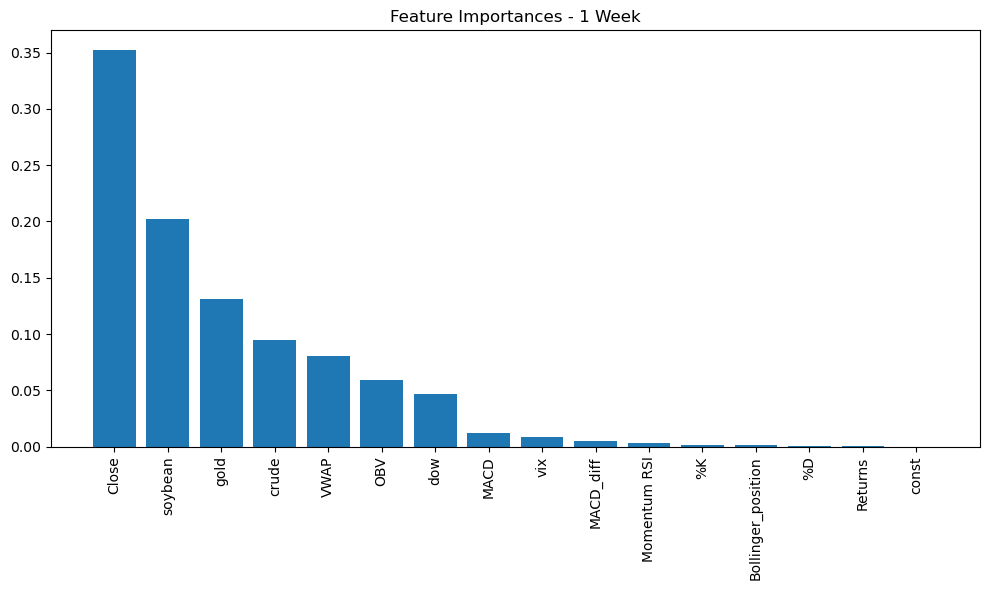

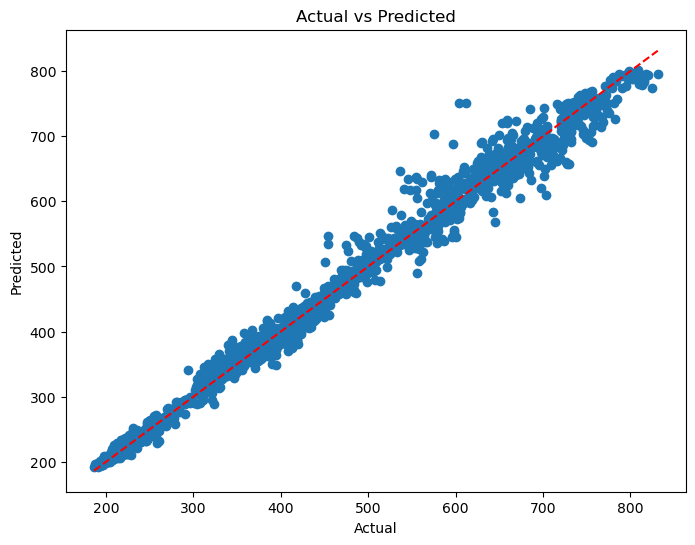

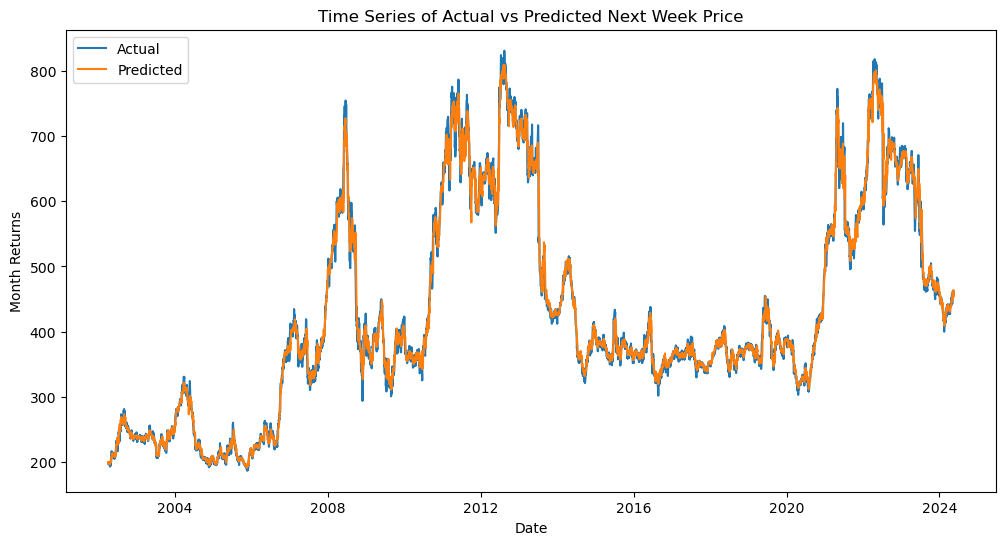

In [37]:

# Visualization: Feature Importance
feature_importances = rf_best_month.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - 1 Week")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_week)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

y_pred_week_full = rf_best_week.predict(X_full)

plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, y, label='Actual')
plt.plot(merged_df.index, y_pred_week_full, label='Predicted')
plt.title('Time Series of Actual vs Predicted Next Week Price')
plt.xlabel('Date')
plt.ylabel('Month Returns')
plt.legend()
plt.show()

In [38]:
X = merged_df.loc[:, x_vars] #Selecting only from merged_df
y = merged_df['Month Price']
    
    #Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    
    # Add constant term to X_train and X_test
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [39]:
# Set up Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Get the best hyperparameters
best_params = study.best_params

# Train the model with the best hyperparameters
rf_best_month = RandomForestRegressor(**best_params, random_state=42)
rf_best_month.fit(X_train, y_train)

# Evaluate the model
y_pred_month = rf_best_month.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_month)
rmse = root_mean_squared_error(y_test, y_pred_month)
mse = mean_squared_error(y_test, y_pred_month)

print(f"Best Hyperparameters: {best_params}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Squared Error(MSE): {mse:.2f}")

[I 2024-06-26 15:58:52,624] A new study created in memory with name: no-name-3dd50b76-6360-4199-b0aa-1876f9d62a71
[I 2024-06-26 15:59:49,515] Trial 0 finished with value: 551.079196998089 and parameters: {'n_estimators': 855, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 0 with value: 551.079196998089.
[I 2024-06-26 16:00:49,685] Trial 1 finished with value: 611.9934234705291 and parameters: {'n_estimators': 821, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 0 with value: 551.079196998089.
[I 2024-06-26 16:00:59,664] Trial 2 finished with value: 576.281061237236 and parameters: {'n_estimators': 538, 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 0 with value: 551.079196998089.
[I 2024-06-26 16:01:02,942] Trial 3 finished with value: 517.2289839332868 and parameters: {'n_estimators': 179, 'max_depth': 15, 'min_samples_spl

Best Hyperparameters: {'n_estimators': 619, 'max_depth': 26, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
Mean Absolute Error (MAE): 11.06
Root Mean Squared Error (RMSE): 16.95
Mean Squared Error(MSE): 287.34


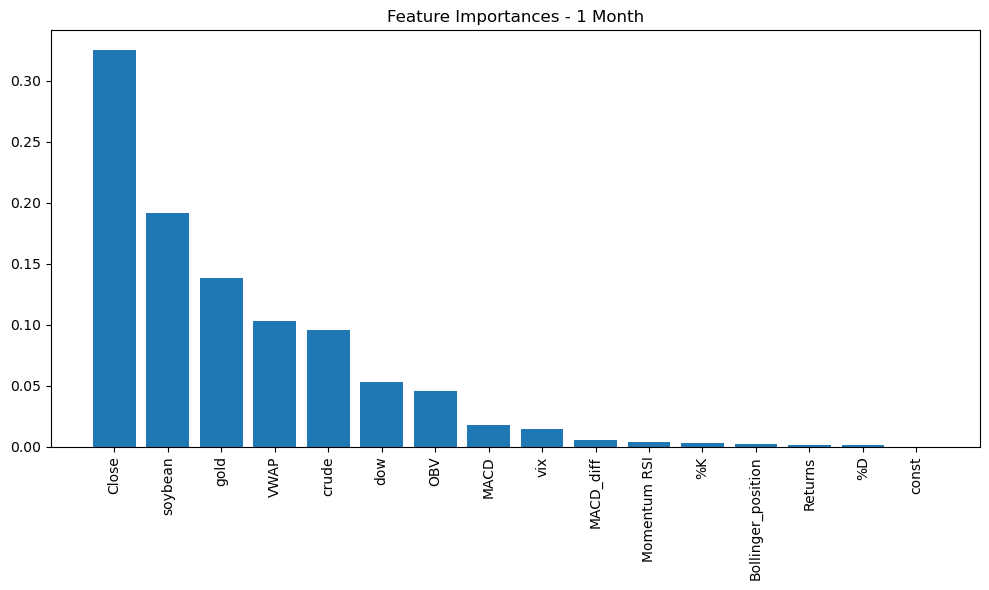

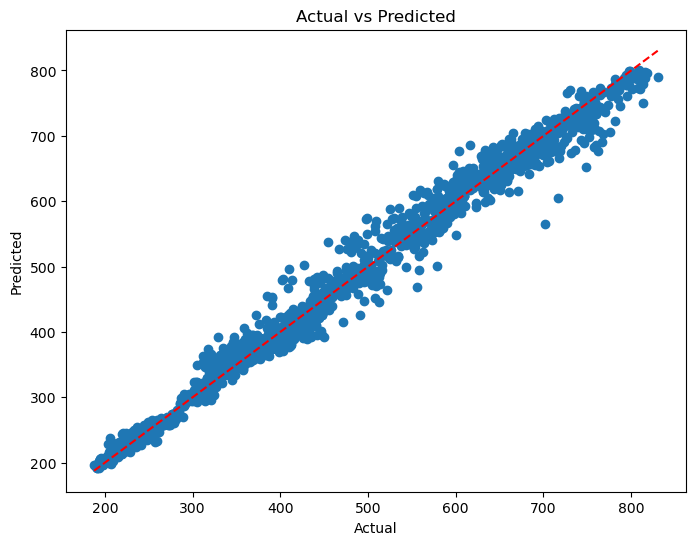

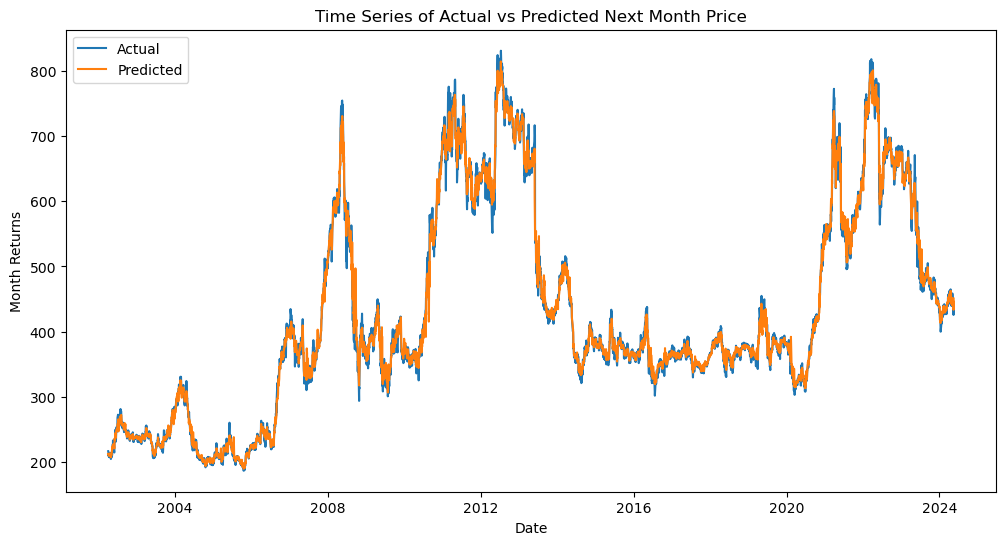

In [40]:
feature_importances = rf_best_month.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - 1 Month")
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_month)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

y_pred_month_full = rf_best_month.predict(X_full)

plt.figure(figsize=(12, 6))
plt.plot(merged_df.index, y, label='Actual')
plt.plot(merged_df.index, y_pred_month_full, label='Predicted')
plt.title('Time Series of Actual vs Predicted Next Month Price')
plt.xlabel('Date')
plt.ylabel('Month Returns')
plt.legend()
plt.show()

In [51]:
pred_1m = y_pred_month_full
pred_1w = y_pred_week_full
#renaming just bc we don't need to differentiate between the train/test split dfs from earlier
close_data  = X_full
#buy/sell signal dveeloped by degree of difference between pred price and actual
# follows function signal = (pred - close)/(|pred - close| + 1)
#function approaches 1 as prediction grows over close, and vice versa
#will likely need to be fine tuned
#then, to get the mixed signal, I average the short and medium run predictions
def generate_individual_signals(X_full, pred_1w, pred_1m):
    data = pd.DataFrame()
    data['pred_1w'] = pred_1w
    data['pred_1m'] = pred_1m
    data.index = X_full.index

    data['signal_1w'] = (data['pred_1w'] - X_full['Close'])/(abs(data['pred_1w'] - X_full['Close'])+1) 
    data['signal_1m'] = (data['pred_1m'] - X_full['Close'])/(abs(data['pred_1m'] - X_full['Close'])+1)
    data['mixed_signal'] = (data['signal_1m'] + data['signal_1w'])/2
    return data

trading_df = generate_individual_signals(X_full,pred_1w, pred_1m )
print(trading_df)


               pred_1w     pred_1m  signal_1w  signal_1m  mixed_signal
2002-04-05  199.421851  212.155493  -0.675129   0.914204      0.119537
2002-04-08  196.962881  212.317447  -0.791106   0.920429      0.064662
2002-04-09  199.026965  210.594103  -0.748303   0.895769      0.073733
2002-04-10  199.639149  211.803312  -0.616983   0.913445      0.148231
2002-04-11  198.192320  210.616317  -0.358019   0.922278      0.282129
...                ...         ...        ...        ...           ...
2024-05-09  450.706191  441.965267   0.888345  -0.439692      0.224327
2024-05-10  454.895716  438.951131  -0.460708  -0.943817     -0.702262
2024-05-13  459.634181  446.638530   0.531436  -0.922248     -0.195406
2024-05-14  454.058256  433.411551   0.235623  -0.953136     -0.358756
2024-05-15  463.309453  450.653877   0.447347  -0.922156     -0.237404

[5548 rows x 5 columns]


In [55]:
print(trading_df.describe())

           pred_1w      pred_1m    signal_1w    signal_1m  mixed_signal
count  5548.000000  5548.000000  5548.000000  5548.000000   5548.000000
mean    426.282787   427.509639     0.056672     0.094406      0.075539
std     156.267115   155.062921     0.805257     0.906700      0.739361
min     190.717328   189.231826    -0.991772    -0.995269     -0.993418
25%     338.809992   342.690368    -0.834362    -0.937445     -0.786158
50%     378.992437   379.308328     0.389730     0.772071      0.041169
75%     541.230697   543.499293     0.866320     0.954648      0.878759
max     809.516299   814.834006     0.987454     0.995230      0.990140


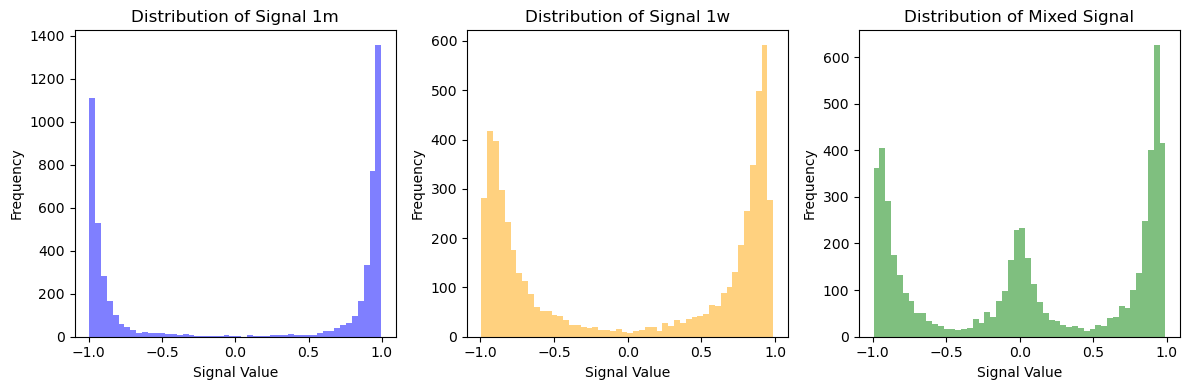

In [53]:

# Create separate figures for each signal
plt.figure(figsize=(12, 4))

# Plot for signal_1m
plt.subplot(1, 3, 1)
plt.hist(trading_df['signal_1m'], bins=50, alpha=0.5, color='blue')
plt.title('Distribution of Signal 1m')
plt.xlabel('Signal Value')
plt.ylabel('Frequency')

# Plot for signal_1w
plt.subplot(1, 3, 2)
plt.hist(trading_df['signal_1w'], bins=50, alpha=0.5, color='orange')
plt.title('Distribution of Signal 1w')
plt.xlabel('Signal Value')
plt.ylabel('Frequency')

# Plot for mixed_signal
plt.subplot(1, 3, 3)
plt.hist(trading_df['mixed_signal'], bins=50, alpha=0.5, color='green')
plt.title('Distribution of Mixed Signal')
plt.xlabel('Signal Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
initial_cash = 100000
cash = initial_cash
position = 0
portfolio_value = []

